In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import os
print(os.getpid())
%cd ../../

colors_ = ["blue", "red", "green", "gray", "black"]

import pylib.mix as mix
import pylib.measurement as mse

28296
/media/work/docs/codes/QuCF/scripts-py


In [2]:
for i in range(100):
    plt.close()

path_qucf_ = "../QuCF/tests/test_inv_sin/"
name_qucf_pr_   = "MI"
name_qucf_file_ = name_qucf_pr_ + "_OUTPUT.hdf5"

--- parameters for block-encoding ---
   nx 	7
   alpha_k0 	-1.429256853470e+00
   alpha_k1 	1.440510844443e+00


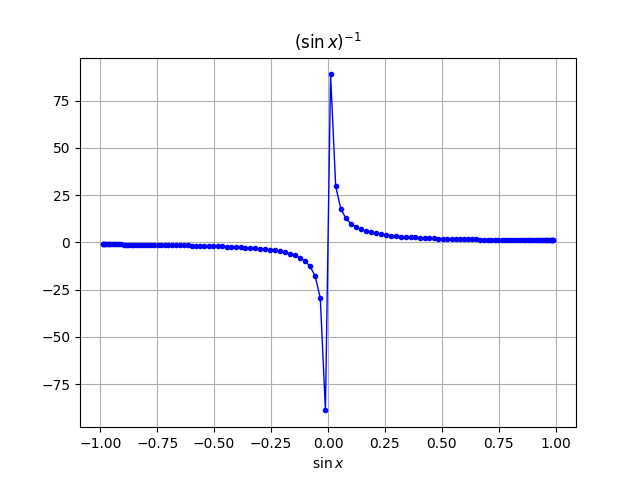

In [9]:
# ------------------------------------------------------------------
# --- Create a reference matrix ---
# ------------------------------------------------------------------
def prepare_ref(xmax):
    # --- Original matrix ---
    
    # --- x grid ---
    Nx_ = 1 << nx_
    x_ = np.linspace(-xmax, xmax, Nx_)

    # --- the function to invert ---
    y = np.sin(x_)

    # --- the singular values of the matrix A encode the input function ---
    A_ = np.diag(y)

    # --- inverse function ---
    y_inv_ref_ = 1. / y

    # --- SIN parameters ---
    alpha_k0 = - xmax 
    alpha_k1 = np.abs(alpha_k0) * Nx_ /(Nx_  - 1)
    print("--- parameters for block-encoding ---")
    print("   nx \t{:d}".format(nx_))
    print("   alpha_k0 \t{:0.12e}".format(alpha_k0))
    print("   alpha_k1 \t{:0.12e}".format(alpha_k1))

    # --- Plotting the initial function ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.sin(x_), y_inv_ref_, color='b', marker = ".", linewidth = 1, linestyle='-')
    plt.xlabel('$\sin{x}$')
    plt.title("$(\sin{x})^{-1}$")
    plt.grid(True)
    plt.show()

    return x_, Nx_, A_, y_inv_ref_
# --------------------------------------------------------------
nx_, kappa_qucf_ = 7, 1e2
xmax_ = np.arcsin(0.99)
x_, Nx_, A_, y_inv_ref_ = prepare_ref(xmax_)

In [8]:
# ----------------------------------------------------------
# --- Compute the condition number ---
# ----------------------------------------------------------
from numpy import linalg as LA
def compute_kappa():
    evals, evecs = LA.eig(A_)
    kappa = np.max(np.abs(evals)) / np.min(np.abs(evals))
    print("nx: \t{:d}".format(nx_))
    print("cond. number: {:0.1f}".format(kappa))
    return
# ----------------------------------------------------------------
compute_kappa()

nx: 	7
cond. number: 88.0


Reading the file ../QuCF/tests/test_inv_sin//MI_OUTPUT.hdf5...
Name of the simulation is MI
Simulation has been performed  01-03-2025 18:20:15

QSVT kappa: 1.0e+02

max. relative err: 1.286e-03


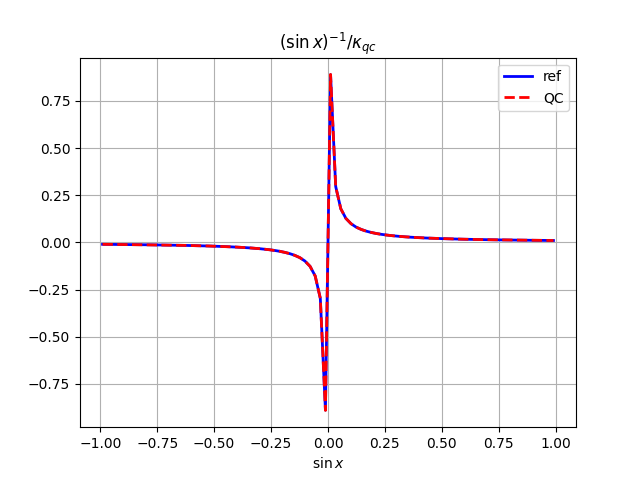

/tmp/ipykernel_28296/3894306651.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


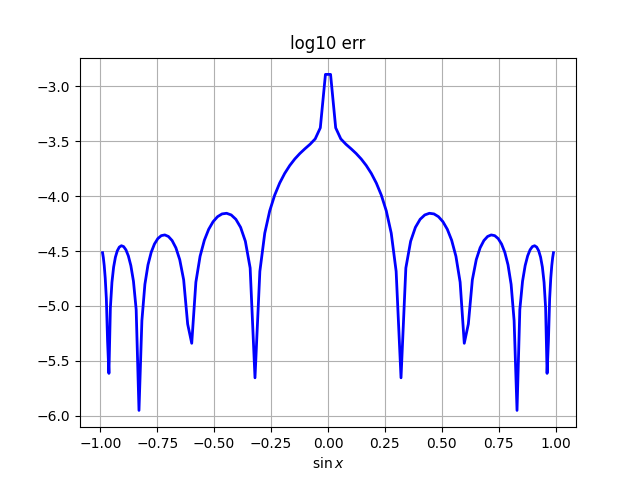

In [20]:
# -------------------------------------------------
# --- Compare with QuCF simulations ---
# -------------------------------------------------
mix.reload_module(mse)
def compare_with_qucf():
    # --- Reading data from the QSVT simulations ---
    om        = mse.MeasOracle__(True)
    om.path_  = path_qucf_
    om.pname_ = "MI"
    om.open()

    # --- QSVT parameter ---
    om.read_qsvt()
    kappa_qc = om.dd_["qsvt_mi"]["par"]
    print()
    print("QSVT kappa: {:0.1e}".format(kappa_qc))

    # --- Normalize the reference case ---
    y_ref_norm = y_inv_ref_ / kappa_qc

    # --- QuCF data ---
    om.set_zero_ancillae_work_states(0)
    qc_data_all = om.get_var_x({}, "rs")

    # --- correct the global phase if necessary ---
    y_inv_qc_ = qc_data_all.imag  
    if y_inv_qc_[0] > 0:
        y_inv_qc_ *= -1 

    # --- renormalization of the QSVT signal ---
    y_inv_qc_ *= 2**(nx_/2.) / om.dd_["qsvt_mi"]["rescaling_factor"]

    # --- Relative error ---
    norm_diff = y_ref_norm - y_inv_qc_
    max_rel_err = np.max(np.abs(norm_diff))

    log_norm_diff = np.zeros(Nx_)
    for ix in range(Nx_):
        v = np.abs(norm_diff[ix])
        if v < 1e-12:
            v = 1e-12
        log_norm_diff[ix] = np.log10(v)
    print()
    print("max. relative err: {:0.3e}".format(max_rel_err))

    # --- Plotting: comparison ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(
        np.sin(x_), y_ref_norm, 
        color='b', linewidth = 2, linestyle='-',  
        label = "ref"
    )
    ax.plot(
        np.sin(x_), y_inv_qc_,
        color='r', linewidth = 2, linestyle='--',  
        label = "QC"
    )
    plt.xlabel('$\sin{x}$')
    plt.title("$(\sin{x})^{-1}/\kappa_{qc}$")
    ax.legend()
    plt.grid(True)
    plt.show()

    # --- Plotting: error ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.sin(x_), log_norm_diff, color='b', linewidth = 2, linestyle='-')
    plt.xlabel('$\sin{x}$')
    plt.title("log10 err")
    plt.grid(True)
    plt.show()
    return
# ----------------------------------------------------------
compare_with_qucf()